In [ ]:
"""
Task:
given a trajectory with each waypoint being joint angles, determine the veloctiy, time and acceleration.

Input:
x_0, x_1, ..., x_N
v_0

Output:
v_0, v_1, ..., v_N
t_0, t_1, ..., t_N
a_0, a_1, ..., a_N
"""

# here we try using spline interpolation to solve the task
# since each segment can be uniquely determined by:
# (t_0, x_0, v_0, t_1, x_1, v_1)
# by setting v_0 and v_1 to be max values, and modifying t_0 and t_1,
# we can probably find good values
# cubic spline: assume the model as:
# x(t) = A + Bt + Ct^2 + Dt^3
import numpy as np
import scipy as sy

# define limits
v_max = 10 * np.pi / 180
a_max = 100 * np.pi / 180


# first try one segment
x0 = np.random.random() * 2*np.pi - np.pi
x1 = np.random.random() * 2*np.pi - np.pi
x2 = np.random.random() * 2*np.pi - np.pi
v0 = np.zeros(1)
# based on x0 and x2, determine v1
if x0 < x1 and x1 < x2:
    v1 = v_max
elif x0 > x1 and x1 > x2:
    v1 = -v_max
else:
    v1 = 0.
v2 = 0.

# fit the spline
# equation:
# x0 = A
# x1 = A + Bt + Ct^2 + Dt^3
# v0 = B
# v1 = B + 2Ct + 3Dt^2
# a = 2C + 6Dt

# => C = 1/t^2 (3x1 - tv1 - 3A - 2Bt)
# conceptually, extend the line horizontally should make the derivative smaller
def cubic_track_seg(x0, v0, x1, v1):
    t = 1.0
    while True:
        A = x0
        B = v0
        C = (1/(t**2)) * (3*x1 - t*v1 - 3*A - 2*B*t)
        D = (v1 - B - 2*C*t) / 3 / (t*t)
        a0 = 2*C
        a1 = 2*C + 6*D*t
#         print('a_max: ')
#         print(a_max)
#         print('a0: ')
#         print(a0)
#         print('a1: ')
#         print(a1)
        if np.abs(a0).max() > a_max or np.abs(a1).max() > a_max:
            t = t * 1.5
        else:
            break
        print('a0: ')
        print(a0)
        print('a1: ')
        print(a1)
    assert np.linalg.norm(A - x0) < 1e-4
    assert np.linalg.norm(B - v0) < 1e-4
    assert np.linalg.norm(A + B*t + C*t*t + D*t*t*t - x1) < 1e-4
    assert np.linalg.norm(B + 2*C*t + 3*D*t*t - v1) < 1e-4

    return t, A, B, C, D

def cubic_track_traj(pos_traj, v0):
    # scan the entire trajectory to define the values for each velocity
    vel_traj = []
    vel_traj.append(v0)
    time_traj = [0.]
    As = []
    Bs = []
    Cs = []
    Ds = []
    for i in range(1, len(pos_traj)-1):
        # compare with neighbor values, determine the current value
        v = np.zeros(v0.shape)
        v[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = v_max
        v[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = -v_max
        vel_traj.append(v)
    vel_traj.append(np.zeros(v0.shape))
    # determine the durations
    for i in range(len(pos_traj)-1):
        t, A, B, C, D = cubic_track_seg(pos_traj[i], vel_traj[i], pos_traj[i+1], vel_traj[i+1])
        time_traj.append(time_traj[-1]+t)
        As.append(A)
        Bs.append(B)
        Cs.append(C)
        Ds.append(D)
    return vel_traj, time_traj, As, Bs, Cs, Ds
    

In [ ]:
# randomly create a bunch of waypoints
import matplotlib.pyplot as plt
pos_traj = np.random.random((10, 2)) * np.pi * 2 - np.pi
v0 = np.zeros(2)
vel_traj, time_traj, As, Bs, Cs, Ds = cubic_track_traj(pos_traj, v0)
colors = ['red', 'blue']
for i in range(len(pos_traj)-1):
    # plot segment: x = A + B(t-time_traj[i]) + C(t-time_traj[i])^2 + D(t-time_traj[i])^3
    ts = np.linspace(time_traj[i], time_traj[i+1], 100)
    print(ts-time_traj[i])
    for j in range(len(As[i])):
        pos = As[i][j] + Bs[i][j] * (ts-time_traj[i]) + Cs[i][j] * ((ts-time_traj[i])**2) + Ds[i][j] * ((ts-time_traj[i])**3)
        plt.plot(ts, pos, c=colors[j])
        plt.scatter([time_traj[i]],[pos_traj[i][j]], c=colors[j])
#         print('joint %d' % (j))
#         print(pos_traj[i+1][j])
#         print(pos[-1])
plt.show()

In [ ]:
import torch
import torch.optim as optim
from torch.autograd import Variable
relu = torch.nn.functional.relu

In [ ]:
def torch_track_traj(pos_traj, init_vel, verbose=False):
    # using pytorch to track the trajectory
    # var: v0, v1/2, v1, t0, t1, t for each segment and each dim
    # initialize
    vel_traj = []
    vel_traj.append(init_vel)
    time_traj = [0.]
    As = []
    Bs = []
    Cs = []
    Ds = []
    vel_half = []
    time_half = []
    time0 = []
    time1 = []
    time_var = []
    for i in range(1, len(pos_traj)-1):
        # compare with neighbor values, determine the current value
        v = np.zeros(v0.shape)
        v[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = v_max
        v[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = -v_max
        vel_traj.append(v)
    vel_traj.append(np.zeros(v0.shape))
    for i in range(len(pos_traj)-1):
        vel_half.append((vel_traj[i]+vel_traj[i+1]) / 2)
        time_half.append(np.zeros(len(pos_traj[0])))
        time0.append(np.ones(len(pos_traj[0])))
        time1.append(np.ones(len(pos_traj[0])))
        time_var.append(2.)
    vel_zero_mask = np.abs(vel_traj) <= 1e-8
    vel_zero_mask = torch.from_numpy(vel_zero_mask)
    # use the vel_traj as init values (for vel=0 we don't treat them as opt vars)
    
    # define constraints for each segment and opt obj.
    vel_traj_var = np.array(vel_traj)
#     vel_traj_var = torch.from_numpy(vel_traj_var)
    #vel_traj_var = Variable(vel_traj_var)
    vel_traj_var = torch.tensor(vel_traj_var, requires_grad=True)
    vel_half = np.array(vel_half)
#     vel_half = torch.from_numpy(vel_half)
#     vel_half = Variable(vel_half)
    vel_half = torch.tensor(vel_half, requires_grad=True)
    time_half = np.array(time_half)
#     time_half = torch.from_numpy(time_half)
#     time_half = Variable(time_half)
    time_half = torch.tensor(time_half, requires_grad=True)
    time0 = np.array(time0)
#     time0 = torch.from_numpy(time0)
#     time0 = Variable(time0)
    time0 = torch.tensor(time0, requires_grad=True)
    time1 = np.array(time1)
#     time1 = torch.from_numpy(time1)
#     time1 = Variable(time1)
    time1 = torch.tensor(time1, requires_grad=True)
    time_var = np.array(time_var)
#     time_var = torch.from_numpy(time_var)
#     time_var = Variable(time_var)
    time_var = torch.tensor(time_var, requires_grad=True)
    opt = optim.SGD([vel_traj_var, vel_half, time0, time_half, time1, time_var], lr=0.001)
    losses = []
    for iter in range(1000):
        loss = 0.
        for i in range(len(pos_traj)-1):
            dx = pos_traj[i+1] - pos_traj[i]
            dx = torch.from_numpy(dx)
            x_dif = (vel_traj_var[i] + vel_half[i]) / 2 * time0[i] + \
                    (vel_half[i] + vel_traj_var[i+1]) / 2 * time1[i] + \
                    vel_half[i] * time_half[i] -dx

            t_dif = time0[i] + time1[i] + time_half[i] - time_var[i]
            a_ll = -a_max * time0[i] - (vel_half[i] - vel_traj_var[i])
            a_ul = (vel_traj_var[i+1] - vel_half[i]) - a_max * time1[i]
            
            v0_ll = -v_max - vel_traj_var[i]
            v0_ul = vel_traj_var[i] - v_max
            v1_ll = -v_max - vel_traj_var[i+1]
            v1_ul = vel_traj_var[i+1] - v_max
            v_half_ll = -v_max - vel_half[i]
            v_half_ul = vel_half[i] - v_max
            t0_ll = 0.1 - time0
            t_half_ll = 0 - time_half
            t1_ll = 0.1 - time1
            
            loss += torch.mean(x_dif ** 2) + torch.mean(t_dif ** 2)
            ineq_const = relu(a_ll) + relu(a_ul) + relu(v0_ll) + relu(v0_ul) + relu(v1_ll) + relu(v1_ul) + \
                         relu(v_half_ll) + relu(v_half_ul) + relu(t0_ll) + relu(t_half_ll) + relu(t1_ll)
            loss += torch.mean(ineq_const)
            if verbose:
                print('loss for segment %d: ' % (i))
                print('x_dif: ')
                print(x_dif ** 2)
                print('t_dif: ')
                print(t_dif ** 2)
                print('a_ll: ')
                print(a_ll)
                print('a_ul: ')
                print(a_ul)
                print('v0_ll: ')
                print(v0_ll)
                print('v0_ul: ')
                print(v0_ul)            
                print('v1_ll: ')
                print(v1_ll)
                print('v1_ul: ')
                print(v1_ul)
                print('v_half_ll: ')
                print(v_half_ll)
                print('v_half_ul: ')
                print(v_half_ul)
                print('t0_ll: ')
                print(t0_ll)
                print('t_half_ll: ')
                print(t_half_ll)
                print('t1_ll: ')
                print(t1_ll)

        print('iteration %d... loss: %f' % (iter, loss))
        loss.backward()
        opt.step()
        losses.append(loss.data.item())
        # clamp vars with 0 velocity (enforced so)
        with torch.no_grad():
            if verbose:
                print('before setting 0...')
                print(vel_traj_var)
                print('mask: ')
                print(vel_zero_mask)

            vel_traj_var[vel_zero_mask] = 0.
            if verbose:

                print('after setting 0...')
                print(vel_traj_var)
                print('before clamping...')
                print('time0: ')
                print(time0)
                print('time1: ')
                print(time1)
            
            time0[time0<0.1] = 0.1
            time1[time1<0.1] = 0.1
            time_var[time_var<0.1] = 0.1
            time_half[time_half<0.] = 0.
            if verbose:

                print('after clamping...')
                print('time0: ')
                print(time0)
                print('time1: ')
                print(time1)
    plt.plot(losses)

In [ ]:
# randomly create a bunch of waypoints
import matplotlib.pyplot as plt
pos_traj = np.random.random((10, 2)) * np.pi * 2 - np.pi
v0 = np.zeros(2)
torch_track_traj(pos_traj, v0)
# colors = ['red', 'blue']
# for i in range(len(pos_traj)-1):
#     # plot segment: x = A + B(t-time_traj[i]) + C(t-time_traj[i])^2 + D(t-time_traj[i])^3
#     ts = np.linspace(time_traj[i], time_traj[i+1], 100)
#     print(ts-time_traj[i])
#     for j in range(len(As[i])):
#         pos = As[i][j] + Bs[i][j] * (ts-time_traj[i]) + Cs[i][j] * ((ts-time_traj[i])**2) + Ds[i][j] * ((ts-time_traj[i])**3)
#         plt.plot(ts, pos, c=colors[j])
#         plt.scatter([time_traj[i]],[pos_traj[i][j]], c=colors[j])
# #         print('joint %d' % (j))
# #         print(pos_traj[i+1][j])
# #         print(pos[-1])
# plt.show()

In [ ]:
# below use QCQP solver for a simpler model of the problem
# 1. identify vel=0 points
# 2. break the v0=0 and v1=0 points into two points, and take the midpoint as configuration
# 3. formalize it as a constant-acceleration problem, and define it in QCQP
import numpy as np
import cvxpy as cvx
from qcqp import *
v_max = 10. * np.pi / 180
a_max = 100. * np.pi / 180

def qcqp_pos_track(pos_traj, v0):
    # identify vel=0 points
    vel_lls = []
    vel_uls = []
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))
    for i in range(1, len(pos_traj)-1):
        # compare with neighbor values, determine the velocity limit
        vl = np.zeros(v0.shape)
        vu = np.zeros(v0.shape)
        vu[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = v_max
        vl[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = 0.
        vu[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = 0.
        vl[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = -v_max
        vel_lls.append(vl)
        vel_uls.append(vu)
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))
    
    new_pos_traj = []
    # break where v0=0 and v1=0 points into two points, and take the midpoint as new configuration
    new_pos_traj.append(pos_traj[0])
    for i in range(len(pos_traj)-1):
        for j in range(len(v0)):
            if vel_lls[i][j] == 0. and vel_uls[i][j] == 0.:
                new_pos_traj.append((pos_traj[i] + pos_traj[i+1]) / 2)
            new_pos_traj.append(pos_traj[i+1])
    pos_traj = new_pos_traj
    # compute new vel=0 point
    vel_lls = []
    vel_uls = []
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))
    for i in range(1, len(pos_traj)-1):
        # compare with neighbor values, determine the velocity limit
        vl = np.zeros(v0.shape)
        vu = np.zeros(v0.shape)
        vu[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = v_max
        vl[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = 0.
        vu[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = 0.
        vl[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = -v_max
        vel_lls.append(vl)
        vel_uls.append(vu)
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))

    # formalize as a QCQP problem
    # create variable: each velocity and time duration
    # constraint: 
    # - (vi + v_{i+1}) / 2 * ti = delta xi
    # - (v_{i+1} - vi) <= a_max * ti
    # - (v_{i+1} - vi) >= a_min * ti
    # - vi <= v_max
    # - vi >= v_min
    vel_vars = [v0]
    t_vars = []
    consts = []  # constraints
    sum_t = 0.
    for i in range(1,len(pos_traj)):
        vel_vars.append(cvx.Variable(2))
        t_vars.append(cvx.Variable())
        consts.append((vel_vars[i] + vel_vars[i-1])/2*t_vars[i-1] == pos_traj[i]-pos_traj[i-1])
        consts.append((vel_vars[i] - vel_vars[i-1]) <= a_max * t_vars[i-1])
        consts.append((vel_vars[i] - vel_vars[i-1]) >= -a_max * t_vars[i-1])
        consts.append(vel_vars[i] <= vel_uls[i])
        consts.append(vel_vars[i] >= vel_lls[i])
        consts.append(t_vars[i-1] >= 0.)
        sum_t += t_vars[i-1]
    obj = cvx.Minimize(sum_t)
    prob = cvx.Problem(obj, consts)
    
    # create QCQP handler
    qcqp = QCQP(prob)
    
    # solve the SDP relaxation and get a starting point to a local method
    qcqp.suggest(SDR)
    print('SDR lower bound: %.3f' % (qcqp.sdr_bound))
    
    # attempt to improve the starting point given by the suggested method
    f_cd, v_cd = qcqp.improve(COORD_DESCENT)
    print("Coordinate descent: objective %.3f, violation %.3f" % (f_cd, v_cd))
    print(x.value)
    
    
pos_traj = np.random.random((10, 2)) * np.pi * 2 - np.pi
v0 = np.zeros(2)

qcqp_pos_track(pos_traj, v0)

In [ ]:
# below use a Linear Program + guessing time for the problem
# 1. identify vel=0 points
# 2. break the v0=0 and v1=0 points into two points, and take the midpoint as configuration
# 3. formalize it as a constant-acceleration problem, and define it in QCQP
# 4. guess initial solution to time, and use the velocity constraint in QCQP as objective to construct a Convex Optimization problem
# 5. solve the Convex Optimization problem. If velocity constraint is violated, then increase the time
import numpy as np
import cvxpy as cvx
v_max = 10. * np.pi / 180
a_max = 100. * np.pi / 180

def qcqp_pos_track(pos_traj, v0):
    # identify vel=0 points
    vel_lls = []
    vel_uls = []
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))
    for i in range(1, len(pos_traj)-1):
        # compare with neighbor values, determine the velocity limit
        vl = np.zeros(v0.shape)
        vu = np.zeros(v0.shape)
        vu[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = v_max
        vl[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = 0.
        vu[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = 0.
        vl[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = -v_max
        vel_lls.append(vl)
        vel_uls.append(vu)
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))
    
    new_pos_traj = []
    # break where v0=0 and v1=0 points into two points, and take the midpoint as new configuration
    new_pos_traj.append(pos_traj[0])
    for i in range(len(pos_traj)-1):
        break_point = False
        for j in range(len(v0)):
            if vel_lls[i][j] == 0. and vel_uls[i][j] == 0.:
                break_point = True
                break
        if break_point:
            new_pos_traj.append((pos_traj[i] + pos_traj[i+1]) / 2)
        new_pos_traj.append(pos_traj[i+1])
    pos_traj = new_pos_traj
    # compute new vel=0 point
    vel_lls = []
    vel_uls = []
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))
    for i in range(1, len(pos_traj)-1):
        # compare with neighbor values, determine the velocity limit
        vl = np.zeros(v0.shape)
        vu = np.zeros(v0.shape)
        vu[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = v_max
        vl[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = 0.
        vu[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = 0.
        vl[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = -v_max
        vel_lls.append(vl)
        vel_uls.append(vu)
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))

    # formalize as a Convex Optimization Problem
    # create variable: each velocity and time duration
    # constraint: 
    # - (vi + v_{i+1}) / 2 * ti = delta xi
    # - (v_{i+1} - vi) <= a_max * ti
    # - (v_{i+1} - vi) >= a_min * ti
    # - vi <= v_max  => objective: max(0, vi-v_max)
    # - vi >= v_min  => objective: max(0, v_min-vi)
    
    # initialize t
    t_vars = []
    for i in range(len(pos_traj)-1):
        t_vec = np.zeros(pos_traj[i].shape)
        t1 = (pos_traj[i+1]-pos_traj[i]) * 2 / (vel_uls[i] + vel_uls[i+1])
        t2 = (pos_traj[i+1]-pos_traj[i]) * 2 / (vel_lls[i] + vel_lls[i+1])
        t_vec[pos_traj[i+1]>pos_traj[i]] = t1[pos_traj[i+1]>pos_traj[i]]
        t_vec[pos_traj[i+1]<pos_traj[i]] = t1[pos_traj[i+1]<pos_traj[i]]
        t = np.max(t_vec)
        t = max(t, 0.1)  # set a small time as lower bound
        t_vars.append(t)
        print(t)
    t_vars = np.array(t_vars)
    k = 0
    while True:
#         if k ==1:
#             break
        print('iter: %d' % (k))
        print(t_vars)

        k += 1
        vel_vars = [v0]
        consts = []  # constraints
    #     sum_t = 0.
        sum_vel_ul = 0.
        sum_vel_ll = 0.
        sum_acc_ul = 0.
        sum_acc_ll = 0.
        sum_pos_loss = 0.
        for i in range(1,len(pos_traj)):
            if i == len(pos_traj)-1:
                vel_vars.append(np.zeros(2))
            else:
                vel_vars.append(cvx.Variable(2))
            dx_2 = (pos_traj[i]-pos_traj[i-1]) * 2
            v_cal_dx = (vel_vars[i] + vel_vars[i-1])*t_vars[i-1]
            consts.append(cvx.abs(v_cal_dx-dx_2) <= np.pi/180 * 2)
            acc = (vel_vars[i] - vel_vars[i-1]) / t_vars[i-1]
            consts.append(cvx.abs(acc) <= a_max)
            sum_vel_ul += cvx.maximum(vel_vars[i] - vel_uls[i], np.zeros(v0.shape))
            sum_vel_ll += cvx.maximum(vel_lls[i] - vel_vars[i], np.zeros(v0.shape))

        prob = cvx.Problem(cvx.Minimize(cvx.sum(sum_vel_ul + sum_vel_ll)), consts)
        # The optimal objective value is returned by `prob.solve()`.
        #result = prob.solve(verbose=True)
        #result = prob.solve(solver=cvx.SCS, verbose=True, use_indirect=True)
        result = prob.solve(solver='CVXOPT', verbose=True)
        print(prob.status)
        if prob.status == 'infeasible':
            # increase all time
            idx = np.argmin(t_vars)
            t_vars[idx] = t_vars[idx] * 1.5
            #t_vars = t_vars * 1.5
        else:
            if result > np.pi / 180:
                # find the place to increase time
                for i in range(1, len(pos_traj)):
                    if i < len(pos_traj)-1 and ((vel_vars[i].value-vel_uls[i]>0) | (vel_vars[i].value-vel_lls[i]<0)).sum()>0:
                        t_vars[i-1] = t_vars[i-1] * 1.5
            else:
                break
            
    print("status:", prob.status)
    print("optimal value", prob.value)
    print('final time:')
    print(t_vars)
    # The optimal value for x is stored in `x.value`.
    for i in range(1, len(vel_vars)):
        print('vel_vars[i]: ')
        if i < len(vel_vars)-1:
            print(vel_vars[i].value)
        else:
            print(vel_vars[i])
    t_traj = []
    v_traj = []
    v_traj = [vel_vars[0]]
    t_traj.append(0.)
    for i in range(1,len(vel_vars)-1):
        v_traj.append(vel_vars[i].value)
        t_traj.append(t_traj[-1]+t_vars[i-1])
    v_traj.append(vel_vars[-1])
    t_traj.append(t_traj[-1]+t_vars[-1])
    return pos_traj, v_traj, t_traj
    
pos_traj = np.random.random((10, 2)) * np.pi * 2 - np.pi
v0 = np.zeros(2)

pos_traj, v_traj, t_traj = qcqp_pos_track(pos_traj, v0)


import matplotlib.pyplot as plt
pos_traj = np.random.random((10, 2)) * np.pi * 2 - np.pi
v0 = np.zeros(2)
pos_traj, vel_traj, time_traj = qcqp_pos_track(pos_traj, v0)
colors = ['red', 'blue']
# for i in range(len(pos_traj)-1):
#     ts = np.linspace(time_traj[i], time_traj[i+1], 100)
#     print(ts-time_traj[i])
#     for j in range(len(As[i])):
#         plt.plot(ts, pos, c=colors[j])
#         plt.scatter([time_traj[i]],[pos_traj[i][j]], c=colors[j])
# #         print('joint %d' % (j))
# #         print(pos_traj[i+1][j])
# #         print(pos[-1])
pos_traj = np.array(pos_traj)
for j in range(2):
    plt.plot(time_traj, pos_traj[:,j], c=colors[j])

plt.show()

infeasible
optimal
optimal
optimal
optimal
optimal
optimal
optimal
1.1272306476251105e-10
status: optimal
optimal value 1.1272306476251105e-10
time: 
[17.0859375 17.0859375 17.0859375 17.0859375 17.0859375 17.0859375
 17.0859375 17.0859375 17.0859375]
[17.0859375 17.0859375 17.0859375 17.0859375 17.0859375 17.0859375
 17.0859375 17.0859375 17.0859375]
[17.0859375 17.0859375 17.0859375 17.0859375 17.0859375 17.0859375
 17.0859375 17.0859375 17.0859375]
vel_uls: 
[0. 0.]
vel_lls:
[-0.17453293  0.        ]
vel_vars[i]: 
[-6.69711954e-02  3.11362004e-14]
vel_uls: 
[0. 0.]
vel_lls:
[0. 0.]
vel_vars[i]: 
[2.56634133e-14 3.52616959e-14]
vel_uls: 
[0. 0.]
vel_lls:
[0. 0.]
vel_vars[i]: 
[ 5.50134178e-14 -4.49749129e-15]
vel_uls: 
[0. 0.]
vel_lls:
[-0.17453293  0.        ]
vel_vars[i]: 
[-5.27970196e-02  1.00950288e-13]
vel_uls: 
[0. 0.]
vel_lls:
[ 0.         -0.17453293]
vel_vars[i]: 
[ 1.80496887e-14 -1.44790508e-02]
vel_uls: 
[0. 0.]
vel_lls:
[ 0.         -0.17453293]
vel_vars[i]: 
[-5.718555

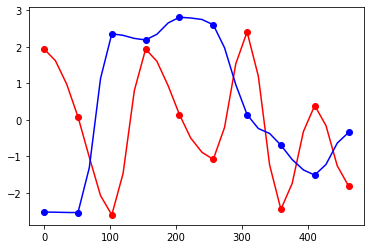

In [7]:
# below use a Linear Program + guessing time for the problem
# 1. identify vel=0 points
# 2. break the v0=0 and v1=0 points into two points, and take the midpoint as configuration
# 3. formalize it as a constant-acceleration problem, and define it in QCQP
# 4. guess initial solution to time, and use the velocity constraint in QCQP as objective to construct a Convex Optimization problem
# 5. solve the Convex Optimization problem. If velocity constraint is violated, then increase the time
import numpy as np
import cvxpy as cvx
v_max = 10. * np.pi / 180
a_max = 100. * np.pi / 180

def qcqp_pos_track(pos_traj, v0):
    # identify vel=0 points
    vel_lls = []
    vel_uls = []
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))
    for i in range(1, len(pos_traj)-1):
        # compare with neighbor values, determine the velocity limit
        vl = np.zeros(v0.shape)
        vu = np.zeros(v0.shape)
        vu[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = v_max
        vl[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = 0.
        vu[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = 0.
        vl[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = -v_max
        vel_lls.append(vl)
        vel_uls.append(vu)
    vel_lls.append(np.zeros(v0.shape))
    vel_uls.append(np.zeros(v0.shape))
    

    t_0s = np.zeros(len(pos_traj)-1) + 1.0
    t_1s = np.zeros(len(pos_traj)-1) + 1.0
    t_2s = np.zeros(len(pos_traj)-1) + 1.0

    while True:
        vel_vars = [v0]
        vel_halfs = []
        consts = []  # constraints
    #     sum_t = 0.
        sum_vel_ul = 0.
        sum_vel_ll = 0.
        for i in range(1,len(pos_traj)):
            if i == len(pos_traj)-1:
                vel_vars.append(np.zeros(2))
            else:
                vel_vars.append(cvx.Variable(2))
            vel_halfs.append(cvx.Variable(2))
            first_seg = (vel_vars[i-1] + vel_halfs[i-1]) / 2 * t_0s[i-1]
            second_seg = vel_halfs[i-1] * t_1s[i-1]
            third_seg = (vel_vars[i] + vel_halfs[i-1]) / 2 * t_2s[i-1]
    #         consts.append((vel_vars[i] + vel_vars[i-1])*t_vars[i-1] == (pos_traj[i]-pos_traj[i-1]) * 2)
            consts.append(first_seg + second_seg + third_seg == (pos_traj[i] - pos_traj[i-1]))
            consts.append((vel_halfs[i-1] - vel_vars[i-1]) <= a_max * t_0s[i-1])
            consts.append((vel_halfs[i-1] - vel_vars[i-1]) >= -a_max * t_0s[i-1])
            consts.append((vel_vars[i] - vel_halfs[i-1]) <= a_max * t_2s[i-1])
            consts.append((vel_vars[i] - vel_halfs[i-1]) >= -a_max * t_2s[i-1])

            sum_vel_ul += cvx.maximum(vel_vars[i] - vel_uls[i], np.zeros(v0.shape))
            sum_vel_ll += cvx.maximum(vel_lls[i] - vel_vars[i], np.zeros(v0.shape))
            
            vel_half_ul = np.maximum(vel_uls[i], vel_uls[i-1])
            vel_half_ll = np.minimum(vel_lls[i], vel_lls[i-1])
            for j in range(len(vel_half_ul)):
                if vel_half_ul[j] == 0. and vel_half_ll[j] == 0.:
                    vel_half_ul[j] = v_max
                    vel_half_ll[j] = -v_max
            
            sum_vel_ul += cvx.maximum(vel_halfs[i-1] - vel_half_ul, np.zeros(v0.shape))
            sum_vel_ll += cvx.maximum(vel_half_ll - vel_halfs[i-1], np.zeros(v0.shape))

            #     obj = cvx.Minimize(sum_t)
        prob = cvx.Problem(cvx.Minimize(cvx.sum(sum_vel_ul + sum_vel_ll)), consts)
        
        result = prob.solve(solver='CVXOPT')
        print(prob.status)
        if prob.status == 'infeasible':
            # increase all time
            t_0s = t_0s * 1.5
            t_1s = t_1s * 1.5
            t_2s = t_2s * 1.5
            # find the smallest one to increase
#             idx1 = np.argmin(t_0s)
#             idx2 = np.argmin(t_1s)
#             idx3 = np.argmin(t_2s)
            
        else:
            # check if optimal value is small enough
            if result > np.pi / 180:
                # check which constraint is violated
                for i in range(1, len(vel_vars)):
                    inc = False
                    if i < len(vel_vars)-1 and ((vel_vars[i].value-vel_uls[i]>0) | (vel_vars[i].value-vel_lls[i]<0)).sum()>0:
                        # increase the time
                        inc = True
                    if ((vel_halfs[i-1].value-vel_uls[i]>0) | (vel_halfs[i-1].value-vel_lls[i]<0)).sum()>0:
                        inc = True
                    if inc:
                        t_0s[i-1] = t_0s[i-1] * 1.5
                        t_1s[i-1] = t_1s[i-1] * 1.5
                        t_2s[i-1] = t_2s[i-1] * 1.5
                        # increase the smallest one
#                         min_t = np.min([t_0s[i-1], t_1s[i-1], t_2s[i-1]])
#                         if t_0s[i-1] == min_t:
#                             t_0s[i-1] = t_0s[i-1] * 1.5
            else:
                break
                        
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    print(result)

    print("status:", prob.status)
    print("optimal value", prob.value)
    print('time: ')
    print(t_0s)
    print(t_1s)
    print(t_2s)
    # The optimal value for x is stored in `x.value`.
    for i in range(1, len(vel_vars)-1):
        print('vel_uls: ')
        print(vel_uls[i])
        print('vel_lls:')
        print(vel_lls[i])
        print('vel_vars[i]: ')
        print(vel_vars[i].value)
    
    # given the solution, obtain the new break points and vel, time
    new_pos_traj = []
    vel_traj = []
    t_traj = []
    vel_traj.append(vel_vars[0])
    t_traj.append(0.)
    new_pos_traj.append(pos_traj[0])
    for i in range(len(pos_traj)-1):
        t0 = t_0s[i]
        t1 = t_1s[i]
        t2 = t_2s[i]
        if i == 0:
            v0 = vel_vars[i]
        else:
            v0 = vel_vars[i].value
        v_half = vel_halfs[i].value
        if i == len(pos_traj)-2:
            v1 = vel_vars[i+1]
        else:
            v1 = vel_vars[i+1].value
        dx = (v0+v_half)/2 * t_0s[i]
        new_pos_traj.append(new_pos_traj[-1] + dx)
        t_traj.append(t0+t_traj[-1])
        vel_traj.append(v_half)
        
        dx = v_half * t_1s[i]
        new_pos_traj.append(new_pos_traj[-1] + dx)
        t_traj.append(t1+t_traj[-1])
        vel_traj.append(v_half)
        
        dx = (v_half+v1)/2 * t_2s[i]
        new_pos_traj.append(new_pos_traj[-1] + dx)
        t_traj.append(t2+t_traj[-1])
        vel_traj.append(v1)
    pos_traj = np.array(new_pos_traj)
    vel_traj = np.array(vel_traj)
    t_traj = np.array(t_traj)
    return pos_traj, vel_traj, t_traj
    
    

import matplotlib.pyplot as plt
pos_traj = np.random.random((10, 2)) * np.pi * 2 - np.pi
ori_pos_traj = np.array(pos_traj)
v0 = np.zeros(2)
pos_traj, vel_traj, time_traj = qcqp_pos_track(pos_traj, v0)
colors = ['red', 'blue']
# for i in range(len(pos_traj)-1):
#     ts = np.linspace(time_traj[i], time_traj[i+1], 100)
#     print(ts-time_traj[i])
#     for j in range(len(As[i])):
#         plt.plot(ts, pos, c=colors[j])
#         plt.scatter([time_traj[i]],[pos_traj[i][j]], c=colors[j])
# #         print('joint %d' % (j))
# #         print(pos_traj[i+1][j])
# #         print(pos[-1])
pos_traj = np.array(pos_traj)

for j in range(2):
    plt.plot(time_traj, pos_traj[:,j], c=colors[j])
    plt.scatter(time_traj[0::3], ori_pos_traj[:,j], c=colors[j])

plt.show()